<a href="https://colab.research.google.com/github/abulhasanat/MachineLearning/blob/master/DMOZ_BERT_Multiclass_Web_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program is to train a model on a sample of dmoz datasets to classify a webpage. This is developed for POC purpose. Lots of work to be done to traing complete training data.

In [0]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [0]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
%%bash
pip install pytorch-pretrained-bert

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=True,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

In [0]:
def _join_texts(texts:Collection[str], mark_fields:bool=False, sos_token:Optional[str]=BOS):
    """Borrowed from fast.ai source"""
    if not isinstance(texts, np.ndarray): texts = np.array(texts)
    if is1d(texts): texts = texts[:,None]
    df = pd.DataFrame({i:texts[:,i] for i in range(texts.shape[1])})
    text_col = f'{FLD} {1} ' + df[0].astype(str) if mark_fields else df[0].astype(str)
    if sos_token is not None: text_col = f"{sos_token} " + text_col
    for i in range(1,len(df.columns)):
        #text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i]
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df[i].astype(str)
    return text_col.values

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# from sklearn.model_selection import train_test_split

# # DATA_ROOT = Path("..") / "input"
DATA_ROOT=Path('/content/drive/My Drive/Data/DMOZ')
df = pd.read_csv(DATA_ROOT / "train.csv")
# train, test = [pd.read_csv(DATA_ROOT / fname,sep='\t') for fname in ["train1.csv", "test1.csv"]]
# val = train # we won't be using a validation set but you can easily create one using train_test_split
try:
  df.drop(['Unnamed: 0'],axis=1,inplace=True)
except:
  pass

In [0]:
df_label= pd.read_csv(DATA_ROOT / 'label.csv')

df=pd.merge(
    left=df,
    right=df_label[['cat_id','top_category']],
    on='cat_id',
    how='inner'
)

In [0]:
train=pd.concat([df,pd.get_dummies(df['top_category'])],axis=1)
train.sample(5)

,cat_id,category,top_category,Adult,Arts,Business,Computers,Games,Health,Home,Kids_and_Teens,News,Recreation,Reference,Science,Shopping,Society,Sports
171537,393.0,Wood Thrush (Hylocichla mustelina)\nNature Jou...,Science,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
89940,247.0,lifescience-software.com\nThis site is under c...,Science,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
184604,41.0,Avoriaz Alpine Ski School\nCLICK HERE FOR FREE...,Sports,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
144437,333.0,Musica Sacra Et Profana: publisher of Early Mu...,Shopping,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
98433,266.0,india visa travel tour rakhi at jrupsindia.com...,Business,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
del df

In [0]:
# try:
#   df.drop(['Unnamed: 0'],axis=1,inplace=True)
# except:
#   pass
# df.dropna(inplace=True)
# df['cat_id']=df['cat_id'].astype(int)

In [0]:
# sample=False
# DATA_ROOT=Path('/content/drive/My Drive/Data/DMOZ')
# df = pd.read_csv(DATA_ROOT / "train.csv")
# try:
#   df.drop(['Unnamed: 0'],axis=1,inplace=True)
# except:
#   pass
# df.dropna(inplace=True)
# df['cat_id']=df['cat_id'].astype(int)
# if sample==True:
#   df_sample=df[df['cat_id']<30]
#   train=pd.concat([df_sample,pd.get_dummies(df_sample['cat_id'], prefix='label')],axis=1)
#   df=df_sample
# else:  
#   # train=df 
#   train=pd.concat([df,pd.get_dummies(df['cat_id'], prefix='label')],axis=1) 
# val=train

# del df

In [0]:
# train, test = train_test_split(train, random_state=42, test_size=0.33, shuffle=True)

In [0]:
val=train

In [0]:
# label_cols=[]
text='Top Stories After Huge Win, Boris Johnson Promises Brexit By Jan 31, "No Ifs, No Buts" States Not Empowered To Block Citizenship Act, Say Government Sources Spent 66% Of Rs 3.38 Lakh Crore Budgeted Expenditure: Economic Advisor \'PM Should Apologise\': Rahul Gandhi Tweets Video Amid "Rape In India" Row "Won\'t Apologise," Says Rahul Gandhi Amid Row Over "Rape In India" Remark Watch: Sri Lanka Player\'s Hilarious Response To Pakistan Journalist More cricket Trending Watch: Steve "Flying" Smith Takes One Of The Best Catches You\'ll Ever See Reviews More Gadgets Reviews Samsung Galaxy A50, Galaxy A70, Galaxy S9 समत कई समसग समरटफन पर बपर डसकउट Samsung Galaxy M11 और Galaxy M31 अगल सल ह सकत ह लनच चर रयर कमर वल Samsung Galaxy A71 और Samsung Galaxy A51 लनच WhatsApp अगल सल स कई समरटफन पर नह करग कम PUBG Mobile in India May Get Privacy Destroying Features Will Nintendo\'s New Switch Consoles Be Better than the PS4 Pro?', 'Tamil Tamil परवततर म CAB क खलफ हसक परदरशन, गवहट म पलस क फयरग म 2 लग क मत गर BJP शसत रजय म CAB क वरध शर, अब पजब क सएम अमरदर सह न कह- बल असवधनक Aus Vs NZ: टम सउद न मर बललबज क गद, बच म भड गए वरनर, बल- \'उसक हथ म लग ह...\' दख Video UK Elections: एगजट पल म पएम बरस जनसन क कजरवटव परट क सपषट बहमत Bravo "Excited About Comeback" After Return To International Cricket Steven Gerrard Signs New Deal At Rangers Until 2024 Greenwood Stars As Man United Top Group, Arsenal Draw In Europa League November Trade Deficit Narrows To $12.', '12 Billion Food Bangladesh Asks India To Increase Guwahati Mission Security Amid Protests தமழ சனம நடகர சததரத அமசசர ஜயகமரகக பதலட..!', 'இநத வரம வளயகம எககசசகக தமழ படஙகள..!', "வபவ-இன டண' பட ரலஸ தத அறவபப..!", 'ஜய-அதலய ரவ ஜட சரம இரணடவத படம..!', 'டடடல வளயடட வறறமறன..!', 'Osteoporosis - Love your Bones Follow These Amazing Tips By Dr Kiran Lohia To Prevent Acne Breakouts Offbeat Baby Yoda To Disappointed Pakistani Fan: A Look At The Best Memes Of 2019 Biggest Parliament Majority For Boris Johnson\'s Party Since Thatcher Days South News No Top Court Order On Plea Of 2 Women For Protection To Enter Sabarimala Cities Nearly 7,000 Trees To Be Cut For Jewar Airport In Uttar Pradesh "We Have Been Cheated...": Teachers After Left Out Of Recruitment Process Campaigns 60,000 Blankets Needed: Help Save Lives, Donate A Blanket For The Homeless, Here\'s How Fighting Our Killer Air Pollution: Check The Air Quality Index Of Your City Chhattisgarh Becomes The Most Efficient State In Waste Management: Government A Startup In Uttarakhand Develops An Eco-Friendly Sanitary Pad That Lasts Five Times Longer Than Regular Pads'

num_labels=df_label['top_category'].nunique()

data={'cat_id':[0],
      'category':[text],
}
test=pd.DataFrame(data)
for labels in df_label['top_category'].unique():
  # label='label_'+str(labels)
  # label_cols.append(label)
  test[labels]=0

test=test.append(test)

In [0]:
test.sample()

,cat_id,category,Science,Society,Computers,Shopping,Business,Recreation,Sports,Health,Reference,Games,Adult,Kids_and_Teens,Home,Arts,News
0,0,"(Top Stories After Huge Win, Boris Johnson Pro...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
label_cols=df_label['top_category'].unique().tolist()
label_cols #[2:]
# label_cols = label_cols[2:]

['Science',
 'Society',
 'Computers',
 'Shopping',
 'Business',
 'Recreation',
 'Sports',
 'Health',
 'Reference',
 'Games',
 'Adult',
 'Kids_and_Teens',
 'Home',
 'Arts',
 'News']

In [0]:
# label_cols=[str(item) for item in label_cols]

In [0]:
label_cols[0]

'Science'

In [0]:
# label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),NumericalizeProcessor(vocab=vocab)]

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [0]:
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="category",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=num_labels)

In [0]:
loss_func = nn.BCEWithLogitsLoss()

In [0]:
from fastai.callbacks import *
device_cuda = torch.device("cuda")
learner = Learner(
    databunch, bert_model,
    loss_func=loss_func
)
if config.use_fp16: learner = learner.to_fp16()
# learner.to_fp32()

In [0]:
# del df

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


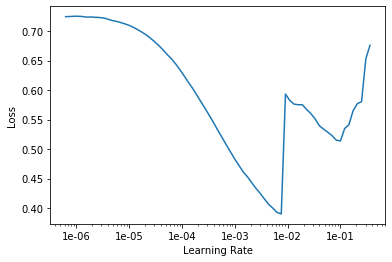

In [0]:
learner.recorder.plot()

In [0]:
# learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)
# learner.fit_one_cycle(config.epochs, max_lr=1e-02)
learner.fit_one_cycle(8, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.655638,0.541433,00:29
1,0.473103,0.260821,00:29
2,0.327268,0.167942,00:29
3,0.233616,0.118160,00:29
4,0.171755,0.091712,00:29
5,0.131496,0.078924,00:29
6,0.106812,0.073497,00:29
7,0.092632,0.072561,00:29


In [0]:
train.cat_id.nunique()

3

In [0]:
learner.export(file=DATA_ROOT/'Model_DMOZ(all_cat_v1_2).pkl')
# learner.export(file=DATA_ROOT/'Model_DMOZ(25_cat).pkl')

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
# learner.load(file=DATA_ROOT/'model1.pkl')
test_preds = get_preds_as_nparray(DatasetType.Test)

In [0]:
# sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")
# if config.testing: sample_submission = sample_submission.head(test.shape[0])
# sample_submission[label_cols] = test_preds
# sample_submission.to_csv(DATA_ROOT /"predictions.csv", index=False)

In [0]:
sample_submission=test
for label in label_cols:
  sample_submission[label]=0
sample_submission[label_cols] = test_preds
# sample_submission.to_csv(DATA_ROOT /"predictions_1.csv", index=False)
# sample_submission.sample(10000).to_csv(DATA_ROOT /"predictions_sample.csv", index=False)


In [0]:
sample_submission.head(5)

,cat_id,category,Science,Society,Computers,Shopping,Business,Recreation,Sports,Health,Reference,Games,Adult,Kids_and_Teens,Home,Arts,News
0,0,"(Top Stories After Huge Win, Boris Johnson Pro...",0.251648,0.037964,0.035411,0.218003,0.033972,0.414129,0.036425,0.034619,0.037187,0.047869,0.035344,0.041385,0.045437,0.035813,0.039862
0,0,"(Top Stories After Huge Win, Boris Johnson Pro...",0.251648,0.037964,0.035411,0.218003,0.033972,0.414129,0.036425,0.034619,0.037187,0.047869,0.035344,0.041385,0.045437,0.035813,0.039862


In [0]:
output=sample_submission.head(1).drop(columns=['cat_id','category']).T
output

,0
Science,0.251648
Society,0.037964
Computers,0.035411
Shopping,0.218003
Business,0.033972
Recreation,0.414129
Sports,0.036425
Health,0.034619
Reference,0.037187
Games,0.047869


In [0]:
output[0]=output[0].astype(float)
output.nlargest(5,[0])

,0
Recreation,0.414129
Science,0.251648
Shopping,0.218003
Games,0.047869
Home,0.045437


In [0]:
sample_submission.to_csv(DATA_ROOT /"predictions_test.csv", index=False)

In [0]:
# learner.export(file=DATA_ROOT /"Model1.pkl")
# learner.save(file=DATA_ROOT/'Final_Model_BERT.pkl')

In [0]:
learner.validate()

[0.07256061]

In [0]:
text='Efforts were being made on Friday to help passengers stranded at the airport, railway station and inter-state bus terminals in Guwahati, an official said.'

In [0]:
x=learner.predict(text)
y=pd.DataFrame(x[2],index=label_cols)
# x[2].shape
y.nlargest(5,[0])

,0
Science,0.466876
Recreation,0.279828
Shopping,0.191933
Games,0.056133
Kids_and_Teens,0.052522
